# Double Dueling Deep Q-Newtork for Ms Pacman v0

In [1]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! mkdir save
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/ > /dev/null 2>&1

--2022-03-06 10:25:26--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M  4.69MB/s    in 2.3s    

2022-03-06 10:25:28 (4.69 MB/s) - ‘Roms.rar’ saved [11128004/11128004]

mkdir: cannot create directory ‘save’: File exists

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /content/ROM/ROMS.zip                                         74% 99%  OK 
All OK


In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torchsummary import summary
import os


In [3]:
def select_device(device=''):
    if device.lower() == 'cuda':
        if not torch.cuda.is_available():
            print ("torch.cuda not available")
            return torch.device('cpu')    
        else:
            return torch.device('cuda:0')
    if device.lower() == 'dml':
        return torch.device('dml')
    else:
        return torch.device('cpu')

import json
def save_history_json(path, data:dict):
    with open(path, mode='w') as f:
        json.dump(data, f)

def load_history_json(path):
    with open(path, 'r') as f:
        n = json.loads(f.read())
    return n

In [4]:
env = gym.make('MsPacman-v0')

In [5]:
AGENT_COLOR = np.array([210, 164, 74]).mean()
N_ACTION = env.action_space.n
N_STATE = (88, 80)
N_EPISODE = 5000
LEARNING_RATE = 0.001
LAMBDA = .98
BATCH_SIZE = 64
MAX_STEP = 50000
CAPACITY_BUFFER = 10000
DEVICE = 'cuda'
PTH_PATH = 'save'

skip_steps = 90  # waiting steps MsPacman-v0 

In [6]:
def preprocess(state):
    state = state[1:176:2, ::2,:].mean(axis=2) # downsample and to gray
    state [ state==AGENT_COLOR] = 0
    state = ((state-128)/128).astype(np.float32)
    return state

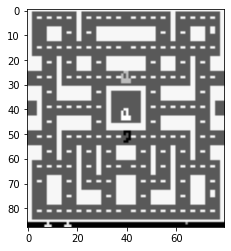

In [ ]:
obs = env.reset()
state = preprocess(obs)
plt.imshow(state, cmap='gray')

In [7]:
#=====REPLAY BUFFER
class ReplayBuffer:
    def __init__(self, capacity, device):
        self.capacity = capacity
        self.size = 0
        self._offset = 0
        # 5 : (state, action, reward, new_state, is_done)
        self.buffer = np.zeros(shape=(capacity, 5), dtype=np.ndarray)
        self.device = device

    def __len__(self):
        return self.size

    def add(self, experience:tuple):
        """
        experience is tuple of ndarray
        """
        self.buffer[self._offset] = experience
        self._offset = (self._offset+1)%self.capacity
        self.size = min(self.size+1, self.capacity)

    def sample(self, batch_size):
        """
        to torch.tensor
        """
        s, a, r, ss, d = self._sample(batch_size)
        s = torch.from_numpy(s).float().to(self.device)
        a = torch.from_numpy(a).long().to(self.device)
        r = torch.from_numpy(r).float().to(self.device)
        ss = torch.from_numpy(ss).float().to(self.device)
        d = torch.from_numpy(d).float().to(self.device)
        return (s, a, r, ss, d)

    def _sample(self, batch_size):
        """
        get samples
        """
        idxes = np.random.choice(self.size, batch_size, replace=False)
        experiences = np.stack(self.buffer[idxes, 0]), np.vstack(self.buffer[idxes, 1]), np.vstack(self.buffer[idxes, 2]), np.stack(self.buffer[idxes, 3]), np.vstack(self.buffer[idxes, 4])
        return experiences


#=====Action Strategies
class ExponentialDecayEGreedyStrategy:
    def __init__(self, start_epsilon=1., end_epsilon=0.1, decay_steps=2000):
        self.step = 0
        self.start_e = start_epsilon
        self.end_e = end_epsilon
        self.decay_steps = decay_steps

    def reset(self):
        self.step = 0

    def _epsilon(self):
        i = self.step 
        self.step+=1
        exp_e = self.start_e* np.power(0.005, (i / self.decay_steps))
        return exp_e * (self.start_e- self.end_e) + self.end_e

    def select_action(self, model, state):
        with torch.no_grad(): 
            pred = model(state).cpu().detach().numpy()
            action = np.argmax(pred) if np.random.rand() > self._epsilon() else np.random.randint(len(pred))
        return action

class GreedyActionStrategy:
    def reset(self): pass

    def select_action(self, model, state):
        with torch.no_grad(): 
            pred = model(state).cpu().detach().numpy()
            action = np.argmax(pred) 
        return action


#=====Network
class DuelingNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, batch_size):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # conv layers
            nn.Conv2d(1, 32, 8, 4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
        )
        # n_dim = self._conv2d_size_calc(input_dim[0], input_dim[1], 8, 4)
        # n_dim = self._conv2d_size_calc(n_dim[0], n_dim[1], 4, 2)
        # n_dim = self._conv2d_size_calc(n_dim[0], n_dim[1], 3, 1)
        # in_size = n_dim[0]*n_dim[1]*batch_size

        self.fc_layer = nn.Sequential(
            # fc layers
            nn.Linear(2688, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
        )
        self.value = nn.Linear(64, 1)
        self.action = nn.Linear(64, output_dim)
    
    # def _conv2d_size_calc(self, w, h, kernel_size=5, stride=2):
    #     next_w = (w - (kernel_size - 1) - 1) // stride + 1
    #     next_h = (h - (kernel_size - 1) - 1) // stride + 1
    #     return next_w, next_h


    def forward(self, state):
        # x = self.preprocess_state(state)
        x = self.conv_layers(state)
        x = self.fc_layer(x)
        a = self.action(x)
        v = self.value(x)

        # # dim of value ouptut is 1. need to expand
        v = v.expand_as(a)
        q = v + a - a.mean(1, keepdim=True).expand_as(a)
        return q



In [ ]:
from torchsummary import summary
model = DuelingNetwork(N_STATE, N_ACTION, BATCH_SIZE)
summary(model, ( 1, 88, 80))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2688]                --
|    └─Conv2d: 2-1                       [-1, 32, 21, 19]          2,080
|    └─BatchNorm2d: 2-2                  [-1, 32, 21, 19]          64
|    └─ReLU: 2-3                         [-1, 32, 21, 19]          --
|    └─Conv2d: 2-4                       [-1, 64, 9, 8]            32,832
|    └─BatchNorm2d: 2-5                  [-1, 64, 9, 8]            128
|    └─ReLU: 2-6                         [-1, 64, 9, 8]            --
|    └─Conv2d: 2-7                       [-1, 64, 7, 6]            36,928
|    └─BatchNorm2d: 2-8                  [-1, 64, 7, 6]            128
|    └─ReLU: 2-9                         [-1, 64, 7, 6]            --
|    └─Flatten: 2-10                     [-1, 2688]                --
├─Sequential: 1-2                        [-1, 64]                  --
|    └─Linear: 2-11                      [-1, 128]                 344,1

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2688]                --
|    └─Conv2d: 2-1                       [-1, 32, 21, 19]          2,080
|    └─BatchNorm2d: 2-2                  [-1, 32, 21, 19]          64
|    └─ReLU: 2-3                         [-1, 32, 21, 19]          --
|    └─Conv2d: 2-4                       [-1, 64, 9, 8]            32,832
|    └─BatchNorm2d: 2-5                  [-1, 64, 9, 8]            128
|    └─ReLU: 2-6                         [-1, 64, 9, 8]            --
|    └─Conv2d: 2-7                       [-1, 64, 7, 6]            36,928
|    └─BatchNorm2d: 2-8                  [-1, 64, 7, 6]            128
|    └─ReLU: 2-9                         [-1, 64, 7, 6]            --
|    └─Flatten: 2-10                     [-1, 2688]                --
├─Sequential: 1-2                        [-1, 64]                  --
|    └─Linear: 2-11                      [-1, 128]                 344,1

In [8]:
class DQNAgent:
    def __init__(self, env, model_fn, model_arg, train_strategy, eval_strategy, device, skip_steps=0):
        self.env = env
        self.target = model_fn(*model_arg).to(device)
        self.online = model_fn(*model_arg).to(device)
        self.update_network()

        self.train_strategy = train_strategy
        self.eval_strategy = eval_strategy
        self.batch = ReplayBuffer(CAPACITY_BUFFER, device)
        self.device = device

        self.game_skip = skip_steps
        self.update_step_count = 100

    
    def update_network(self):
        """
        update the online network into target network
        """
        self.target.load_state_dict(self.online.state_dict())

    def optimize(self, experiences, optim):
        with torch.no_grad():
            states, actions, rewards, next_states, is_dones = experiences
            ## double
            max_a_index = self.online(self.preprocess_state(next_states)).detach().argmax(1)
            max_a_q_value = self.target(self.preprocess_state(next_states)).gather(1, max_a_index.unsqueeze(1))
            target_q_value = rewards + (LAMBDA* max_a_q_value * (1 - is_dones))

        q_value = self.online(self.preprocess_state(states)).gather(1, actions)
        # td_error = q_value -  target_q_value
        optim.zero_grad()
        value_loss = nn.MSELoss()(q_value, target_q_value)
        value_loss.backward()
        optim.step()
 

    def preprocess_state(self, state, dim=1): 
        """
        convert into the torch
        """
        state = torch.tensor(state, device=self.device, dtype=torch.float32)
        return state.unsqueeze(dim)

    def train(self, n_episode, optim_fn, lr, save_step=100, print_step=1):
        optim = optim_fn(self.online.parameters(), lr = lr)
        buffer = ReplayBuffer(CAPACITY_BUFFER, self.device)
        self.online.train()
        self.target.eval()
        total_step = 0
        import time
        start_time = time.time()

        episode_reward = []
        episode_step = []
        episode_egreedy_exp = []
        episode_acc_time = []

        for e in range(n_episode):
            state, is_done = preprocess(env.reset()), False
            step_count = 0
            # skip the waiting steps
            for _ in range(self.game_skip):
                new_state, reward, is_done, _ = self.env.step(0)
                state = preprocess(new_state)
            
            episode_reward.append(0.0)
            episode_step.append(0.0)
            episode_egreedy_exp.append(0.0)
            episode_acc_time.append(0.0)
            
            while True:
                action = self.train_strategy.select_action(self.online, self.preprocess_state(state, 0).unsqueeze(0))
                # get new state and reward from environment
                new_state, reward, is_done, _ = self.env.step(action)
                new_state = preprocess(new_state)

                experience = (state, action, reward, new_state, is_done)
                buffer.add(experience)
                step_count += 1                    
                total_step += 1

                if len(buffer) > BATCH_SIZE:
                    experiences = buffer.sample(BATCH_SIZE)
                    self.optimize(experiences, optim)

                    episode_reward[-1] += reward
                    state = new_state

                    if total_step % self.update_step_count == 0:
                        self.update_network()

                    t = time.time() - start_time

                if is_done or step_count>=MAX_STEP:
                    # terminate the episode
                    episode_step[-1] = step_count
                    episode_egreedy_exp[-1] = self.train_strategy.step
                    episode_acc_time[-1] = t

                    if (e+1) % print_step == 0:
                        print('\tepisode: {}/{} ({:5} steps)  | total reward : {:.3f} | elapsed time: {}m {:.3f}s'.format(e+1, n_episode, step_count, episode_reward[-1], int(t//60), t%60))
                    
                    break

            if (e+1) % save_step == 0:
                # self.save(os.path.join(PTH_PATH, 'ddqn_pacman_{}.pth'.format(e+1)))
                self.save(os.path.join(PTH_PATH, 'ddqn_pacman.pth'))
          


        return {
            'rewards':episode_reward,
            'steps':episode_step,
            'count_exploration':episode_egreedy_exp,
            'acc_time':episode_acc_time
        }

    def eval(self, eval_episodes=100, print_step=10):
        # evaluation
        import time
        eval_reward = []
        eval_acc_time = []
        start_time = time.time()
        for e in range(eval_episodes):
            state, is_done = preprocess(env.reset()), False
            # skip the waiting steps
            for _ in range(self.game_skip):
                new_state, reward, is_done, _ = self.env.step(0)
                state = preprocess(new_state)

            eval_reward.append(0)
            eval_acc_time.append(0)
            for step in range(MAX_STEP):
                a = self.eval_strategy.select_action(self.online, self.preprocess_state(state, 0).unsqueeze(0))
                state, reward, is_done, _ = self.env.step(a)
                eval_reward[-1] += reward
                state = preprocess(state)

                t = time.time() - start_time
                if is_done: 
                    eval_acc_time[-1] = t

                    if (e+1) % print_step == 0:
                        print('\tepisode: {}/{} ({:5} steps)  | total reward : {:.3f} | elapsed time: {}m {:.3f}s'.format(e+1, eval_episodes, step, eval_reward[-1], int(t//60), t%60))
                    break
        return {
            'rewards':eval_reward,
            'acc_time':eval_acc_time
        }

    def save(self, filepath):
        torch.save(self.online.state_dict(), filepath)

    def load(self, filepath):
        state_dict = torch.load(filepath, map_location=self.device)
        self.target.load_state_dict(state_dict)
        self.online.load_state_dict(state_dict)


In [9]:
device = select_device(DEVICE)
agent = DQNAgent(env, DuelingNetwork, (N_STATE, N_ACTION, BATCH_SIZE), ExponentialDecayEGreedyStrategy(1, 0.1, 20000), GreedyActionStrategy(), device, skip_steps)

In [10]:
## LOAD PRETRAINED DATA
agent.load(os.path.join('./save', 'ddqn_pacman.pth'))

In [ ]:
## TRAIN
train_history = agent.train(N_EPISODE, Adam, LEARNING_RATE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


	episode: 1/5000 (  552 steps)  | total reward : 60.000 | elapsed time: 0m 5.250s
	episode: 2/5000 (  455 steps)  | total reward : 70.000 | elapsed time: 0m 9.693s
	episode: 3/5000 (  348 steps)  | total reward : 90.000 | elapsed time: 0m 13.143s
	episode: 4/5000 (  474 steps)  | total reward : 120.000 | elapsed time: 0m 17.741s
	episode: 5/5000 (  559 steps)  | total reward : 70.000 | elapsed time: 0m 23.377s
	episode: 6/5000 (  800 steps)  | total reward : 110.000 | elapsed time: 0m 31.359s
	episode: 7/5000 (  638 steps)  | total reward : 90.000 | elapsed time: 0m 37.807s
	episode: 8/5000 (  675 steps)  | total reward : 110.000 | elapsed time: 0m 44.564s
	episode: 9/5000 (  560 steps)  | total reward : 70.000 | elapsed time: 0m 50.102s
	episode: 10/5000 (  534 steps)  | total reward : 120.000 | elapsed time: 0m 55.531s
	episode: 11/5000 (  432 steps)  | total reward : 110.000 | elapsed time: 0m 59.834s
	episode: 12/5000 (  436 steps)  | total reward : 140.000 | elapsed time: 1m 4.275

In [ ]:
save_history_json(os.path.join('./hist', 'ddqn_pacman_train.json'), train_history)

In [11]:
eval_history = agent.eval()

	episode: 10/100 (  623 steps)  | total reward : 280.000 | elapsed time: 0m 12.738s
	episode: 20/100 (  427 steps)  | total reward : 140.000 | elapsed time: 0m 21.981s
	episode: 30/100 (  574 steps)  | total reward : 290.000 | elapsed time: 0m 32.957s
	episode: 40/100 (  421 steps)  | total reward : 120.000 | elapsed time: 0m 45.322s
	episode: 50/100 (  571 steps)  | total reward : 290.000 | elapsed time: 0m 55.850s
	episode: 60/100 (  403 steps)  | total reward : 110.000 | elapsed time: 1m 6.429s
	episode: 70/100 (  407 steps)  | total reward : 110.000 | elapsed time: 1m 16.729s
	episode: 80/100 ( 1148 steps)  | total reward : 450.000 | elapsed time: 1m 27.667s
	episode: 90/100 (  430 steps)  | total reward : 130.000 | elapsed time: 1m 39.076s
	episode: 100/100 (  444 steps)  | total reward : 120.000 | elapsed time: 1m 48.753s


In [12]:
save_history_json(os.path.join('./hist', 'ddqn_pacman_eval.json'), eval_history)

In [ ]:
# load history datas
train_history = load_history_json(os.path.join('./hist/', 'ddqn_pacman_train.json'))
eval_history = load_history_json(os.path.join('./hist/', 'ddqn_pacman_eval.json'))

In [14]:
print('Test average reward is {}'.format(np.mean(eval_history['rewards'])))

Test average reward is 210.1
